In [1]:
#pip install h5py nibabel pandas glob2 regex
import os
import sys
import numpy as np
import nibabel as nib
import h5py
import time
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tqdm import tqdm
from itertools import product
import scipy
import torch
import torch.nn as nn

In [4]:
#! pip install h5py nibabel pandas glob2 regex

In [4]:
import os
import sys
import time
import h5py
import numpy as np
import torch
import torch.nn as nn

eps = 1e-8  # Small epsilon to avoid division by zero

def runNNLipRemoval2(device, exp, ver, sub):
    sta_epoch = time.time()

    #################################
    ### Lipid Projection Operator ###
    #################################
    s = (64, 64, 32, 960)
    hf = h5py.File('../PaulTrainData/' + sub + '/TrainData/' + 'TrainData_' + ver + '.h5', 'r')
    LipidProj_Operator_ff = np.array(hf['lipid_projOP'])
    
    image_rf = np.array(hf['spectra'])
    if image_rf.shape[0] * 2 > 64 * 64 * 32:
        image_rf = np.concatenate((image_rf, image_rf), axis=0)
    else:
        image_rf = np.concatenate((image_rf, image_rf, image_rf, image_rf), axis=0)
    image_rrrf = np.reshape(image_rf[:64 * 64 * 32], s)

    true_rf = np.array(hf['lipid']) + np.array(hf['water'])
    if true_rf.shape[0] * 2 > 64 * 64 * 32:
        true_rf = np.concatenate((true_rf, true_rf), axis=0)
    else:
        true_rf = np.concatenate((true_rf, true_rf, true_rf, true_rf), axis=0)
    true_rrrf = np.reshape(true_rf[:64 * 64 * 32], s)

    metab_rrrf = image_rrrf - true_rrrf
    
    ####################
    ### Prepare Data ###
    ####################
    headmask = np.ones((64, 64, 32))
    skMask = np.ones((64, 64, 32))
    
    # Extract voxel data (flattened spatial dimensions)
    lip = image_rrrf[headmask > 0, :]      # shape: (num_voxels, 960)
    lipProj = np.matmul(lip, LipidProj_Operator_ff)
    
    # Convert to torch tensors (complex)
    lip = torch.tensor(lip, dtype=torch.cfloat)
    lipProj = torch.tensor(lipProj, dtype=torch.cfloat)
    true = torch.tensor(true_rrrf[headmask > 0, :], dtype=torch.cfloat)
    metab_rf = torch.tensor(metab_rrrf[headmask > 0, :], dtype=torch.cfloat)

    # Save original number of voxels (for later assignment)
    orig_voxel_count = int(headmask.sum())  # e.g., 131072

    # ---------------------------
    # Filter out rows with NaNs in any of the tensors
    valid_mask = (~torch.isnan(lip).any(dim=1)) & (~torch.isnan(lipProj).any(dim=1)) \
                 & (~torch.isnan(true).any(dim=1)) & (~torch.isnan(metab_rf).any(dim=1))
    lip = lip[valid_mask]
    lipProj = lipProj[valid_mask]
    true = true[valid_mask]
    metab_rf = metab_rf[valid_mask]
    valid_indices = np.where(valid_mask.cpu().numpy())[0]
    # ---------------------------

    #####################
    ### Prepare Model ###
    #####################
    for f in os.listdir('../models/' + exp):
        if f.startswith("src"):
            sys.path.insert(0, '../models/' + exp + '/')
            sys.path.insert(0, '../models/' + exp + '/' + f)
            from config import params
            from src.initialize import initialize_model_folder, my_copy
            from src.training import training, validation
            from src.model import yModel
            break

    model = yModel(nLayers=params["nLayers"],
                   nFilters=params["nFilters"],
                   dropout=0,
                   in_channels=params["in_channels"],
                   out_channels=params["out_channels"])
    params["path_to_model"] = "../models/" + exp + "/"
    model.load_state_dict(torch.load(params["path_to_model"] + 'model_last.pt'))
    model.to(device)

    #####################
    ### Remove Lipids ###
    #####################
    Data_LipidRemoved_rf, Data_Lipid_rf, loss, spectra_energy = runModelOnLipData(
        lip=lip,
        lipProj=lipProj,
        true=true,
        metab_rf=metab_rf,
        model=model,
        device=device
    )
    
    # Create full-size (flattened) output arrays with shape (orig_voxel_count, 960)
    Data_LipidRemoved_rf_full = np.zeros((orig_voxel_count, s[-1]), dtype=np.cfloat)
    Data_Lipid_rf_full = np.zeros((orig_voxel_count, s[-1]), dtype=np.cfloat)
    Data_LipidRemoved_rf_full[valid_indices, :] = Data_LipidRemoved_rf.numpy()
    Data_Lipid_rf_full[valid_indices, :] = Data_Lipid_rf.numpy()

    # Reshape back to volume: (64,64,32,960)
    Data_LipidRemoved_rrrf = Data_LipidRemoved_rf_full.reshape(s)
    Data_Lipid_rrrf = Data_Lipid_rf_full.reshape(s)
    
    # Process loss: assign valid losses into full array and reshape to (64,64,32)
    loss_array = np.zeros((orig_voxel_count,), dtype=np.float64)
    loss_array[valid_indices] = np.mean(loss.numpy(), axis=(1,2))
    loss_rrr = loss_array.reshape(headmask.shape)
    
    # Process lipProj similarly
    lipProj_np = lipProj.cpu().numpy()  # shape: (num_valid, 960)
    lipProj_full = np.zeros((orig_voxel_count, s[-1]), dtype=np.cfloat)
    lipProj_full[valid_indices, :] = lipProj_np
    lipProj_rrrf = lipProj_full.reshape(s)

    spectra_energy_full = np.zeros((orig_voxel_count, 1), dtype=np.float64)
    spectra_energy_full[valid_indices, :] = spectra_energy.cpu().numpy()
    spectra_energy_rrr = spectra_energy_full.reshape((headmask.shape[0], headmask.shape[1], headmask.shape[2], 1))
    
    return (Data_LipidRemoved_rrrf, Data_Lipid_rrrf, image_rrrf, 
            lipProj_rrrf, metab_rrrf, true_rrrf, loss_rrr, spectra_energy_rrr)


def runModelOnLipData(lip, lipProj, true, metab_rf, model, device):
    import torch
    import torch.nn as nn

    eps = 1e-8
    # Save a copy of original 'lip' before normalization for de-normalization later
    lip_orig = lip.clone()  # shape: (num_valid, 960) and is complex

    # Compute normalization factor from the difference between lip and lipProj
    spectra_energy = torch.sqrt(torch.sum(torch.abs(lip - lipProj)**2, dim=1) + eps)[:, None]
    spectra_energy = torch.clamp(spectra_energy, min=1e-3)
    
    # Normalize the tensors by dividing by spectra_energy
    lip_norm = lip / spectra_energy
    lip_norm = torch.stack((torch.real(lip_norm), torch.imag(lip_norm)), axis=1)  # shape: (N, 2, 960)
    
    lipProj_norm = lipProj / spectra_energy
    lipProj_norm = torch.stack((torch.real(lipProj_norm), torch.imag(lipProj_norm)), axis=1)
    
    true_norm = true / spectra_energy
    true_norm = torch.stack((torch.real(true_norm), torch.imag(true_norm)), axis=1)
    
    datasz = lipProj_norm.shape[0]
    batchsz = 200
    prediction = torch.zeros((datasz, 2, lip_norm.shape[2]), dtype=torch.float64)
    
    loss_func = nn.MSELoss(reduction='none')
    model.eval()
    with torch.no_grad():
        for i in range(int(datasz / batchsz) + 1):
            percent = (i + 1) / (int(datasz / batchsz) + 1) * 100
            print('Percent: {:.2f}%'.format(percent), end='\r')
            lip_batch = lip_norm[i * batchsz:(i + 1) * batchsz, :, :]
            lipProj_batch = lipProj_norm[i * batchsz:(i + 1) * batchsz, :, :]
            true_batch = true_norm[i * batchsz:(i + 1) * batchsz, :, :]
            
            if lip_batch.shape[0] == 0:
                continue
            lip_batch, lipProj_batch = lip_batch.to(device), lipProj_batch.to(device)
            pred = model(lip_batch, lipProj_batch)[:, :2, :].cpu()  # shape: (batch, 2, 960)
            prediction[i * batchsz:(i + 1) * batchsz, :, :] = pred
    
    loss_input = loss_func(lip_norm, true_norm)
    print('Inp loss:', torch.mean(loss_input).item())
    loss_pred = loss_func(prediction, true_norm)
    print('Pred loss:', torch.mean(loss_pred).item())
    
    prediction_complex = prediction[:, 0] + 1j * prediction[:, 1]
    prediction_complex = prediction_complex * spectra_energy
    # Use the original lip tensor (from our copy) for correct dimensions.
    lip_complex = lip_orig
    Data_LipidRemoved_rf = lip_complex - prediction_complex
    
    return Data_LipidRemoved_rf, prediction_complex, loss_pred, spectra_energy


# Set device, experiment, version, and subject
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
exp =  'test_hauke'#'EXP_3p3'
ver = 'v4_4'
sub = '3DMRSIMAP_Vol_06_A_1_2024-08-22_L2_0p0005'

Data_LipidRemoved_rrrf, Data_Lipid_rrrf, lip_rrrf, lipProj_rrrf, metab_rrrf, nuisance_rrrf, loss_rrr, spectra_energy_rrr = runNNLipRemoval2(
    device=device,
    exp=exp,
    ver=ver,
    sub=sub
)




Inp loss: 2.7462051548354793e-06
Pred loss: 3.265512969733346e-06


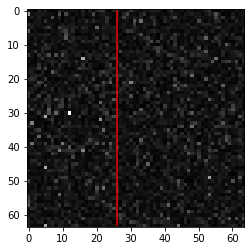

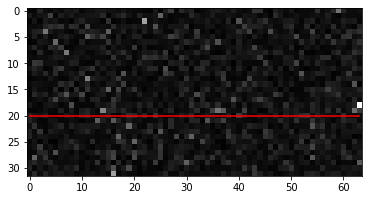

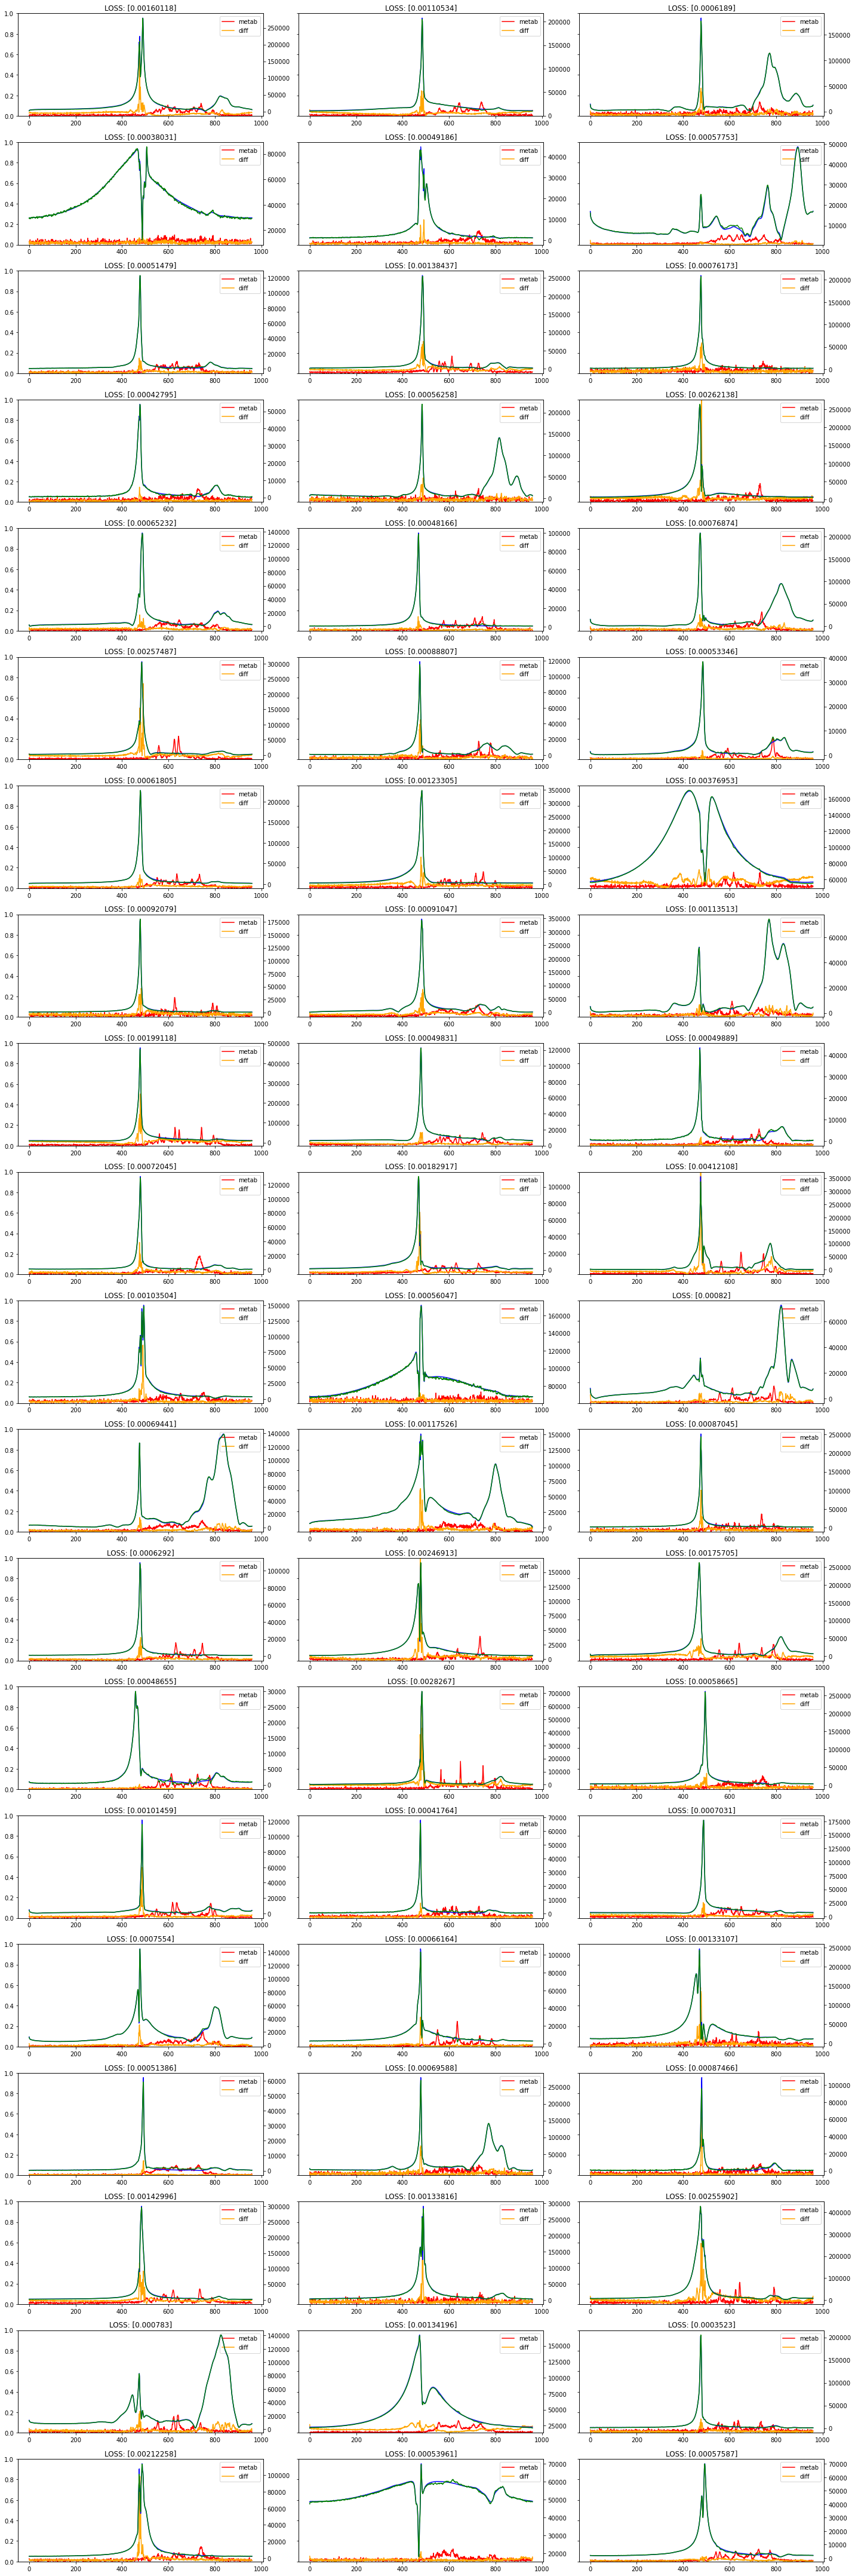

In [5]:
zdim=20
ydim=26

sum_img_grid = np.sum(np.abs(Data_LipidRemoved_rrrf), axis=-1)



plt.imshow(sum_img_grid[:,:,zdim], cmap="gray")
x = [ydim, ydim]
y = [0,63]
plt.plot(x,y,'red')
plt.show()
plt.imshow(np.flip(np.rot90(sum_img_grid[:,ydim,:], k=3), axis=1), cmap="gray")
x = [0,63]
y = [zdim, zdim]
plt.plot(x,y,'red')
plt.show()



fig, ax = plt.subplots(nrows=20, ncols=3, figsize=(20,60), sharey=True)
for i in range(20):
    for ii in range(3):
        sl = i*3 + ii
        metab_energy = np.sqrt(np.sum(np.abs(metab_rrrf[sl,ydim,zdim,:])**2))
        if metab_energy <0.25:
            metab_energy=0.25
        metab_max = np.amax(np.abs(metab_rrrf[sl,ydim,zdim,:]))
        if metab_max <0.001:
            metab_max=0.001
        spectra_energy = spectra_energy_rrr[sl,ydim,zdim]
        norm = metab_energy#/spectra_energy
        
        spec1 = Data_LipidRemoved_rrrf[sl,ydim,zdim,:]/norm#/spectra_energy_rrr[sl,ydim,zdim]
        spec3 = metab_rrrf[sl,ydim,zdim,:]/norm#/spectra_energy_rrr[sl,ydim,zdim]
        ax[i,ii].plot(np.abs(spec3), label='metab', color='red')
        ax[i,ii].plot(np.abs(spec1), label='diff', color='orange')
        ax[i,ii].set_ylim([0,1])
        ax[i,ii].legend()
        
        ax2 = ax[i,ii].twinx()
        
        spec1 = Data_Lipid_rrrf[sl,ydim,zdim,:]
        spec3 = nuisance_rrrf[sl,ydim,zdim,:]
        ax2.plot(np.abs(spec3), label='nuisance', color='blue')
        ax2.plot(np.abs(spec1), label='pred_nuisance', color='green')
        #ax2.set_ylim([0,600])
        #ax2.legend()
        
        
        norm = (metab_energy/spectra_energy)**2
        ax[i,ii].title.set_text('LOSS: ' + str(loss_rrr[sl,ydim,zdim]/norm))
fig.patch.set_facecolor('white')
fig.patch.set_alpha(1)
fig.tight_layout()
#plt.savefig("images/"+exp+'_DS'+ver)
plt.show()